<div>
<img src="./images/sunpy_logo.png" width="500" align="left"/>
</div>

In [1]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from sunpy.time import parse_time
import numpy as np
import matplotlib.pyplot as plt
import glob
import sunpy.map
from sunpy.coordinates import frames, get_body_heliographic_stonyhurst, get_horizons_coord
from astropy.visualization import ImageNormalize, LogStretch
from astropy.wcs import WCS

# 3. Coordinates

SunPy uses [`astropy.coordinates`](https://docs.astropy.org/en/stable/coordinates/index.html) to represent points in physical space. This applies to both points in 3D space and projected coordinates in images.

The SunPy coordinate framework extends the Astropy coordinates framework, and the coordinates subpackage of sunpy provides: 

* A robust framework for working with solar-physics coordinate systems

* Functions to obtain the locations of solar-system bodies (sunpy.coordinates.ephemeris)

* Functions to calculate Sun-specific coordinate information (sunpy.coordinates.sun)

* Bridge module to enable the use of the SkyCoord API to perform computations using SPICE kernels (sunpy.coordinates.spice)



In this notebook we'll introduce some of the powerful functionality available within sunpy

## Coordinate frameword
`sunpy` extends the `astropy.coordinates` framework by adding additional solar-specific coordinate frames and the accompanying transformations between them.

<div>
<img src="./images/coordinates.png"/>
</div>

### Creating coordinates 

We deal with coordinates by using astropy's [`SkyCoord`](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html#astropy.coordinates.SkyCoord) class. 

We have already seem some introduction to this in the previous notebook but lets extend this here!


A **coordinate** combines position data with a coordinate frame, and a SkyCoord object is created by passing in positions with specified units and a coordinate frame. Above in the imports cell we've imported [`sunpy.coordinates.frames`](https://docs.sunpy.org/en/stable/code_ref/coordinates/index.html#supported-coordinate-systems) which allow us to use solar physics specific frames such as Helioprojective, Heliographic Stonyhurst, Heliocentric etc. 

Lets create a point on the Sun in lat and long in the Heliographic Stonyhurst coordinate system

In [2]:
# longitude, latitude
hgs_coord = SkyCoord(10*u.deg, 20*u.deg, obstime="2017-08-01", frame=frames.HeliographicStonyhurst)  
hgs_coord

<SkyCoord (HeliographicStonyhurst: obstime=2017-08-01T00:00:00.000, rsun=695700.0 km): (lon, lat) in deg
    (10., 20.)>

In [3]:
print(f"""Longitude: {hgs_coord.lon}
Latitude: {hgs_coord.lat}
Distance from Sun center: {hgs_coord.radius}""")

Longitude: 10.0 deg
Latitude: 20.0 deg
Distance from Sun center: 1.0


In [4]:
hgs_coord_xyz = SkyCoord(hgs_coord, representation_type='cartesian')
hgs_coord_xyz

<SkyCoord (HeliographicStonyhurst: obstime=2017-08-01T00:00:00.000, rsun=695700.0 km): (x, y, z) [dimensionless]
    (0.92541658, 0.16317591, 0.34202014)>

We can then transform this coordinate to the any defined coordinate frame defined in astropy or sunpy. Lets transform it to the Helioprojective frame (which is observer-based)

In [5]:
hgs_coord.transform_to(frames.Helioprojective(observer="earth"))

<SkyCoord (Helioprojective: obstime=2017-08-01T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (154.89224085, 234.48634082, 1.51172864e+08)>

We can also convert this to other coordinate systems outside the solar-specific ones - for examples ICRS

In [6]:
hgs_coord.transform_to("icrs")

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, km)
    (16.45495249, 16.01388665, 980067.1475033)>

## An important note about observer based frames

Some coordinate frames are defined based on the position of the observer e.g. the Helioprojective and Heliocentric frames. Therefore to transform either of these frames to a different frame the location of the observer must be known.

This is shown above when transforming to Helioprojective we needed to pass an `observer` keyword. Similarly, its important that the `obstime` is given also!

For example, lets define a point on the Sun in Helioprojective and see what that equivalent point would be from another observer - say Mars!


In [7]:
obstime = "2022-05-02 00:00"

In [8]:
hpc_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, observer="earth", 
                     obstime=obstime, frame=frames.Helioprojective)
hpc_coord

<SkyCoord (Helioprojective: obstime=2022-05-02T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (Tx, Ty) in arcsec
    (0., 0.)>

In [9]:
print(hpc_coord.Tx, hpc_coord.Ty)

0 arcsec 0 arcsec


In [10]:
mars_hpc_coord = hpc_coord.transform_to(frames.Helioprojective(observer="mars"))
mars_hpc_coord

<SkyCoord (Helioprojective: obstime=2022-05-02T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'mars'>): (Tx, Ty, distance) in (arcsec, arcsec, AU)
    (-678.66522024, -54.34326175, 1.39871439)>

In [11]:
print(mars_hpc_coord.Tx, mars_hpc_coord.Ty)

-678.665 arcsec -54.3433 arcsec


## Positions of solar system bodies
`sunpy.coordinates` provides functions to obtain the coordinates of solar-system bodies.
The function `get_body_heliographic_stonyhurst` which will return the location of the solar-system body in the `HeliographicStonyhurst` frame.

For other solar-system bodies (e.g., major man-made spacecraft or comets), you can use `get_horizons_coord()`, which queries JPL HORIZONS:

In [12]:
earth_pos = get_body_heliographic_stonyhurst("earth", "2022-04-02")
mars_pos = get_body_heliographic_stonyhurst("mars", "2022-04-02")

In [13]:
print(mars_pos)

<HeliographicStonyhurst Coordinate (obstime=2022-04-02T00:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)
    (93.99183226, 2.12476909, 1.42489458)>


For other solar-system bodies (e.g., major man-made spacecraft or comets), you can use get_horizons_coord(), which queries JPL HORIZONS:

In [14]:
solo_pos = get_horizons_coord("solar orbiter", "2022-04-02")

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


## Plotting positions of spacecraft

Lets plot the positions of different spacecraft over the recent Solar Orbiter perihelion!

In [15]:
perihelion_time = parse_time("2022-04-02")
perihelion_seq = perihelion_time + np.arange(-30, 30)*u.day


In [16]:
solo_coord = get_horizons_coord("solar orbiter", perihelion_seq)
psp_coord = get_horizons_coord("psp", perihelion_seq)
sdo_coord = get_horizons_coord("sdo", perihelion_seq)

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Parker Solar Probe (spacecraft) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac [sunpy.coordinates.ephemeris]


Text(0.5, 1.0, 'Positions in Heliographic Stonyhurst (HGS)')

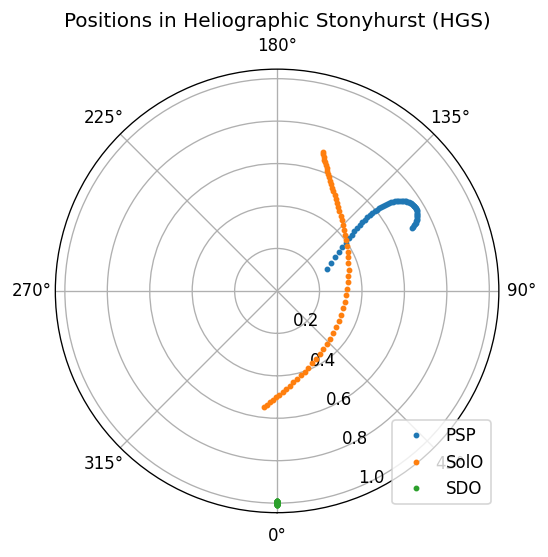

In [17]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot(projection='polar')

# Transform to HGS
psp_coord_hgs = psp_coord.heliographic_stonyhurst
solo_coord_hgs = solo_coord.heliographic_stonyhurst
sdo_coord_hgs = sdo_coord.heliographic_stonyhurst


ax.plot(psp_coord_hgs.lon.to('rad'), psp_coord_hgs.radius,
        '.', markersize=5, label='PSP')
ax.plot(solo_coord_hgs.lon.to('rad'), solo_coord_hgs.radius,
        '.', markersize=5, label='SolO')
ax.plot(sdo_coord_hgs.lon.to('rad'), sdo_coord_hgs.radius,
        '.', markersize=5, label='SDO')


ax.legend(loc='lower right')
ax.set_theta_zero_location("S")
ax.set_title('Positions in Heliographic Stonyhurst (HGS)')

Text(0.5, 1.0, 'Positions in Heliocentric Inertial (HCI)')

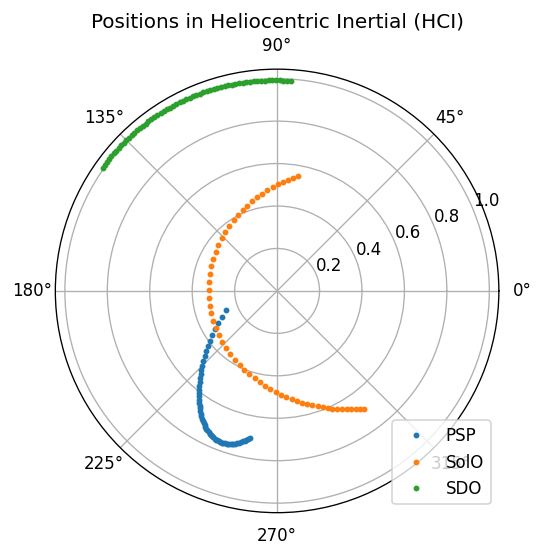

In [18]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot(projection='polar')

# Transform to HCC
psp_coord_hci = psp_coord.heliocentricinertial
solo_coord_hci = solo_coord.heliocentricinertial
sdo_coord_hci = sdo_coord.heliocentricinertial

ax.plot(psp_coord_hci.lon.to('rad'), psp_coord_hci.distance,
        '.', markersize=5, label='PSP')
ax.plot(solo_coord_hci.lon.to('rad'), solo_coord_hci.distance,
        '.', markersize=5, label='SolO')
ax.plot(sdo_coord_hci.lon.to('rad'), sdo_coord_hci.distance,
        '.', markersize=5, label='SDO')

ax.legend(loc='lower right')
ax.set_title('Positions in Heliocentric Inertial (HCI)')

# Observations from different observer locations

## Example of SDO/AIA and Solar Orbiter/EUI

In [19]:
aia_files = glob.glob("./AIA/*171*.fits"); aia_files.sort()
eui_files = glob.glob("./EUI/*174*.fits"); eui_files.sort()

In [20]:
aia_map = sunpy.map.Map(aia_files[10])
eui_map = sunpy.map.Map(eui_files[10])

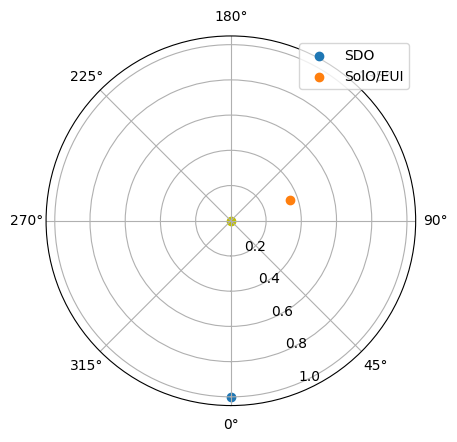

In [73]:
fig = plt.figure()
ax = fig.add_subplot(projection="polar")

ax.scatter(aia_map.observer_coordinate.lon.to('rad'), 
           aia_map.observer_coordinate.radius.to(u.AU), label="SDO")

ax.scatter(eui_map.observer_coordinate.lon.to(u.rad), 
           eui_map.observer_coordinate.radius.to_value(u.AU), label="SolO/EUI")

ax.scatter(0, 0, color='y')
ax.set_theta_zero_location("S")
plt.legend()

<CoordinatesMap with 2 world coordinates:

  index aliases    type   unit    wrap   format_unit visible
  ----- ------- --------- ---- --------- ----------- -------
      0     lon longitude  deg 180.0 deg         deg     yes
      1     lat  latitude  deg      None         deg     yes

>

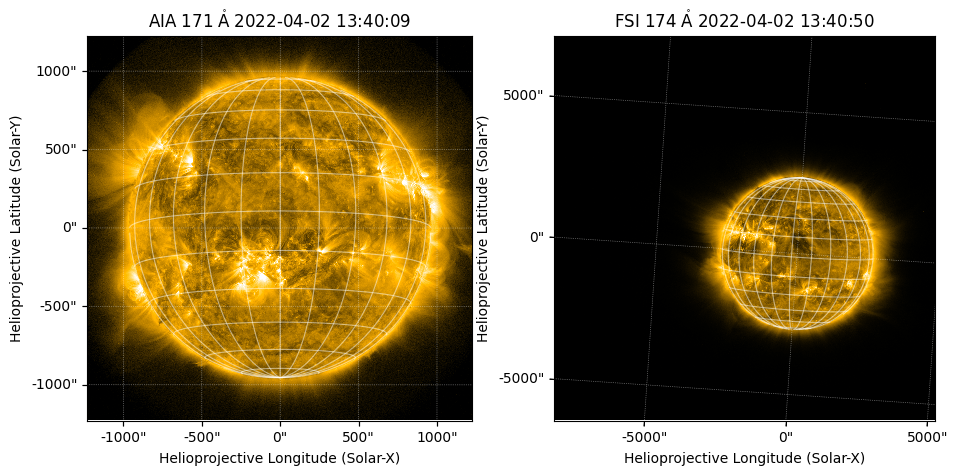

In [74]:
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(1,2,1,projection=aia_map)
ax2 = fig.add_subplot(1,2,2,projection=eui_map)

aia_map.plot(axes=ax1, clip_interval=[5, 99.9]*u.percent)
aia_map.draw_grid()
eui_map.plot(axes=ax2)
eui_map.draw_grid()

### Plot the solar limb as seen from EUI on AIA map

We can plot the solar limb as seen from EUI on the AIA map

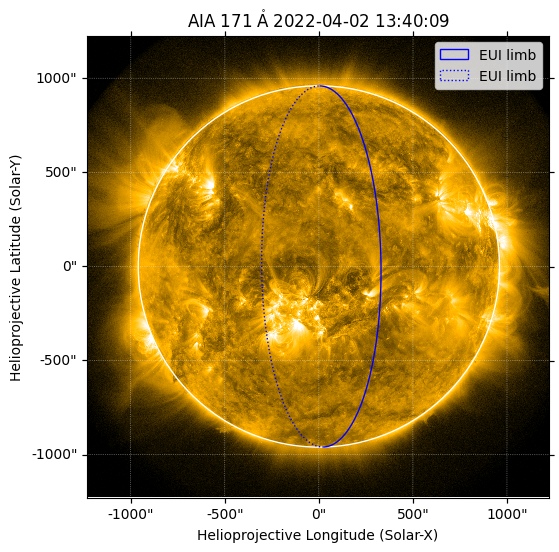

In [75]:
fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_subplot(projection=aia_map)
aia_map.plot(axes=ax1, clip_interval=[5, 99.9]*u.percent)
aia_map.draw_limb(axes=ax1, color='white')
eui_map.draw_limb(axes=ax1, color='blue', label="EUI limb")
plt.legend()

And visa-versa, plot the AIA limb on the EUI map

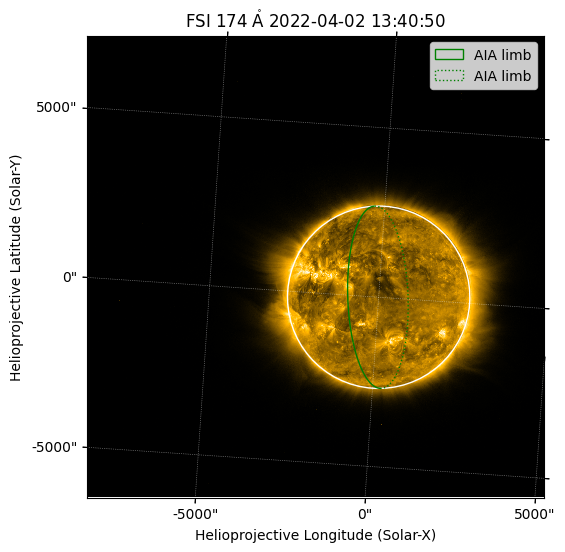

In [76]:
fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_subplot(projection=eui_map)
eui_map.plot(axes=ax1)
eui_map.draw_limb(axes=ax1, color='white')
aia_map.draw_limb(axes=ax1, color='green', label="AIA limb")
plt.legend()



## The solar flare and eruption is both seen by SDO/AIA and from SolO/EUI, just from two different points of view.

Lets define the point and plot the point of the flare as seen by AIA

In [77]:
flare_coord_aia = SkyCoord(830*u.arcsec, 263*u.arcsec, frame=aia_map.coordinate_frame)

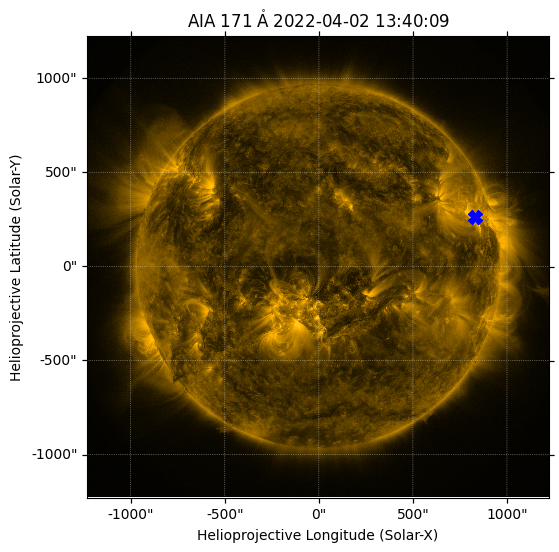

In [78]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection=aia_map)
aia_map.plot()
ax.plot_coord(flare_coord_aia, marker='X', color='b', ms=10)

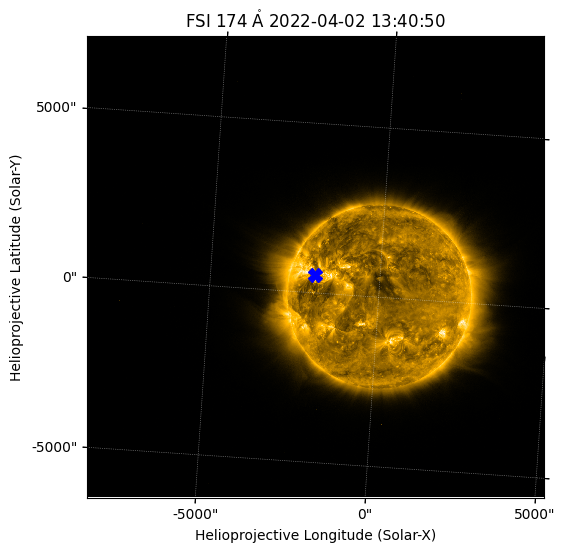

In [79]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection=eui_map)
eui_map.plot()
ax.plot_coord(flare_coord_aia, marker='X', color='b', ms=10)

## Reproject AIA to field of view of Solo

Lets say for this observation, we want to identify what the AIA field of view looks like from the observer of Solar Orbiter. We can do this by using `reproject`.

In [80]:
aia_map = aia_map.resample((512, 512)*u.pix)

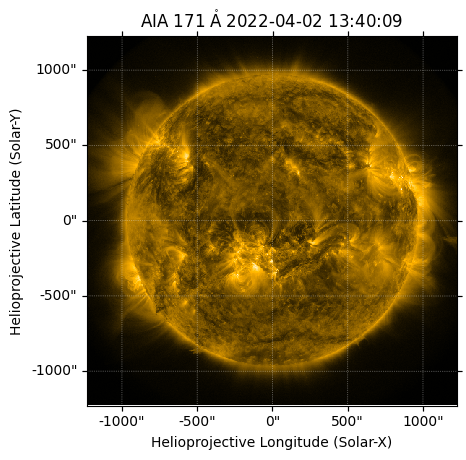

In [81]:
aia_map.plot()

In [82]:
eui_map.meta["rsun_ref"] = sunpy.sun.constants.radius.to_value(u.m)
aia_map.meta["rsun_ref"] = sunpy.sun.constants.radius.to_value(u.m)

(<matplotlib.patches.Circle at 0x14e7fef00>, None)

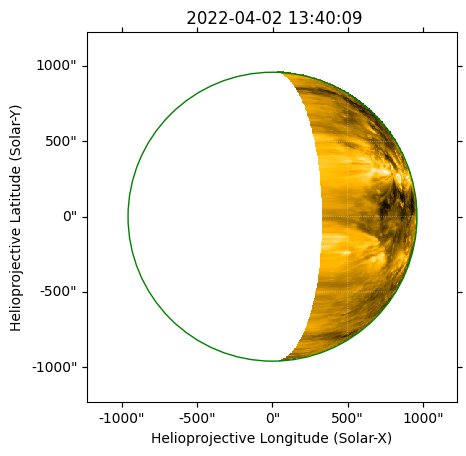

In [95]:
eui_map_reproject_aia = eui_map.reproject_to(aia_map.wcs)
eui_map_reproject_aia.plot()
eui_map_reproject_aia.draw_limb(color='g')

(<matplotlib.patches.Circle at 0x1502c2de0>, None)

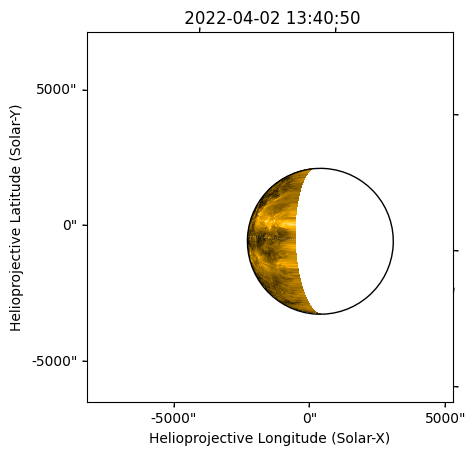

In [94]:
aia_map_reproject_eui = aia_map.reproject_to(eui_map.wcs)

aia_map_reproject_eui.plot()
aia_map_reproject_eui.draw_limb(color='k')

## Reproject to Heliographic Maps

As well as reprojecting to different observers, sunpy maps can also be reprojected to different coordinate frames`

In [96]:
shape_out = (720, 1440)
frame_out = SkyCoord(0, 0, unit=u.deg,
                     frame="heliographic_stonyhurst",
                     obstime=aia_map.date,
                     rsun=aia_map.coordinate_frame.rsun)
header = sunpy.map.make_fitswcs_header(shape_out,
                                       frame_out,
                                       scale=(360 / shape_out[1],
                                              180 / shape_out[0]) * u.deg / u.pix,
                                       projection_code="CAR")
out_wcs = WCS(header)

In [97]:
outmap = aia_map.reproject_to(header)

(<matplotlib.patches.Polygon at 0x15075ac90>, None)

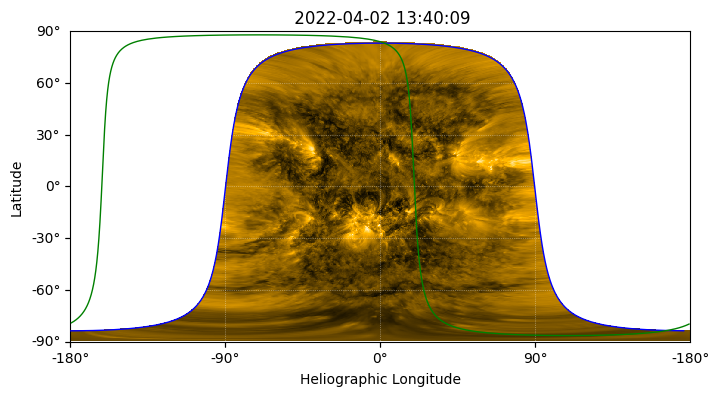

In [98]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection=outmap)
outmap.plot()
aia_map.draw_limb(color='b')
eui_map.draw_limb(color='green')

# Computations using SPICE kernals now available since sunpy 5.1!

SPICE kernels are datasets that provide detailed information on the positions, motions, and orientations of spacecraft and celestial bodies, which essential for precise solar observations and experiments. These kernels allow us to accurately align instruments, predict spacecraft encounters with solar phenomena, and analyze the dynamics of the solar system's bodies in relation to the Sun.

The `sunpy.coordinates.spice` module now enables the use of the `SkyCoord` API to perform SPICE computations such as the location of bodies or the transformation of a vector from one coordinate frame to another coordinate frame.

In [113]:
from sunpy.data import cache
from sunpy.coordinates import spice, frames
from astropy.time import Time

In [114]:
solo_kernal_urls = [
    "spk/de421.bsp",
    "spk/solo_ANC_soc-orbit-stp_20200210-20301120_280_V1_00288_V01.bsp",
]
solo_kernal_urls = [f"http://spiftp.esac.esa.int/data/SPICE/SOLAR-ORBITER/kernels/{url}"
               for url in solo_kernal_urls]

psp_kernals = ["https://spdf.gsfc.nasa.gov/pub/data/psp/ephemeris/spice/Long_Term_Predicted_Ephemeris/spp_nom_20180812_20250831_v039_RO6.bsp"]

kernals = solo_kernal_urls + psp_kernals

kernel_files = [cache.download(url) for url in kernals]
spice.initialize(kernel_files)

In [115]:
obstime = Time("2020-03-01") + np.arange(0, 1767, 1)*u.day
solo_spacecraft = spice.get_body('Solar Orbiter', obstime)
psp_spacecraft = spice.get_body('SOLAR PROBE PLUS', obstime)

solo_spacecraft_hgs = solo_spacecraft.heliographic_stonyhurst
psp_spacecraft_hgs = psp_spacecraft.heliographic_stonyhurst

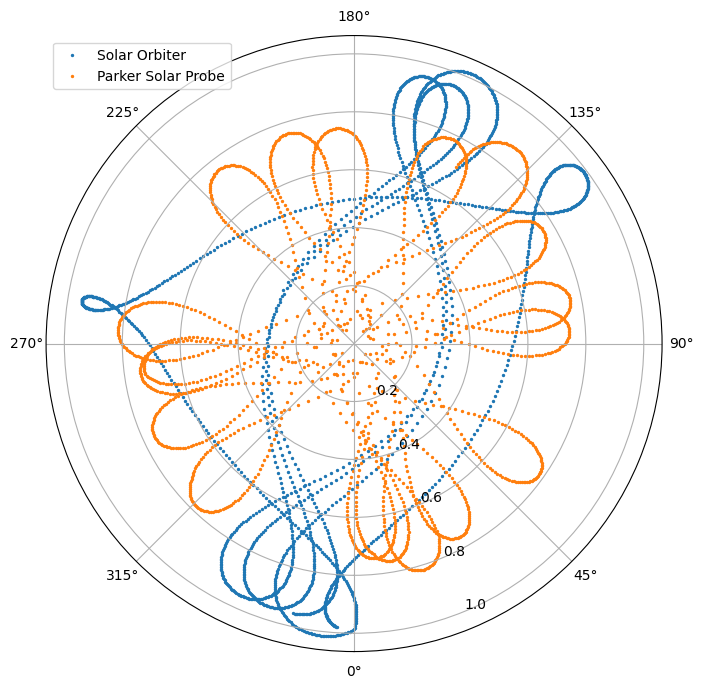

In [116]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='polar')
im = ax.scatter(solo_spacecraft_hgs.lon.to(u.rad), solo_spacecraft_hgs.radius.to(u.au), s=2, label="Solar Orbiter")
im2 = ax.scatter(psp_spacecraft_hgs.lon.to(u.rad), psp_spacecraft_hgs.radius.to(u.au), s=2, label="Parker Solar Probe")
ax.set_theta_zero_location("S")
plt.legend()
plt.show()

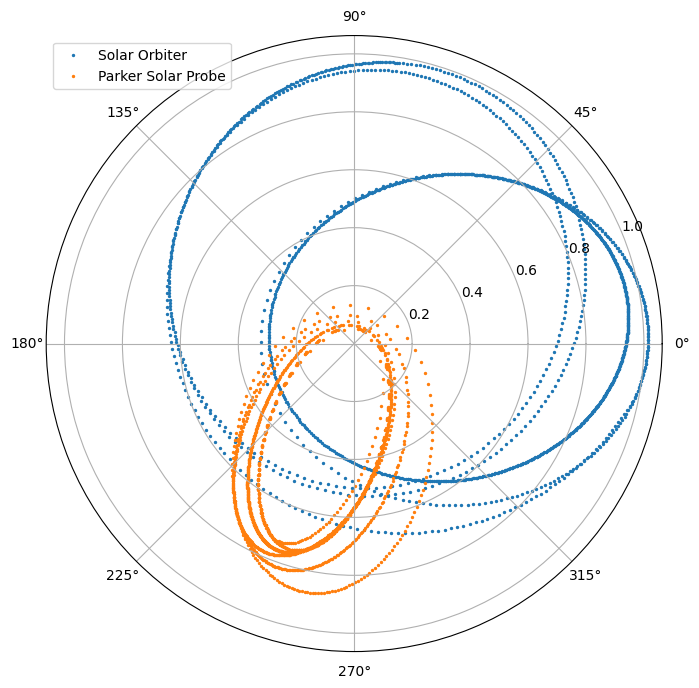

In [117]:
solo_spacecraft_hci = solo_spacecraft.heliocentricinertial
psp_spacecraft_hci = psp_spacecraft.heliocentricinertial

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='polar')
im = ax.scatter(solo_spacecraft_hci.lon.to(u.rad), solo_spacecraft_hci.distance.to(u.au), s=2, label="Solar Orbiter")
im2 = ax.scatter(psp_spacecraft_hci.lon.to(u.rad), psp_spacecraft_hci.distance.to(u.au), s=2, label="Parker Solar Probe")

plt.legend()

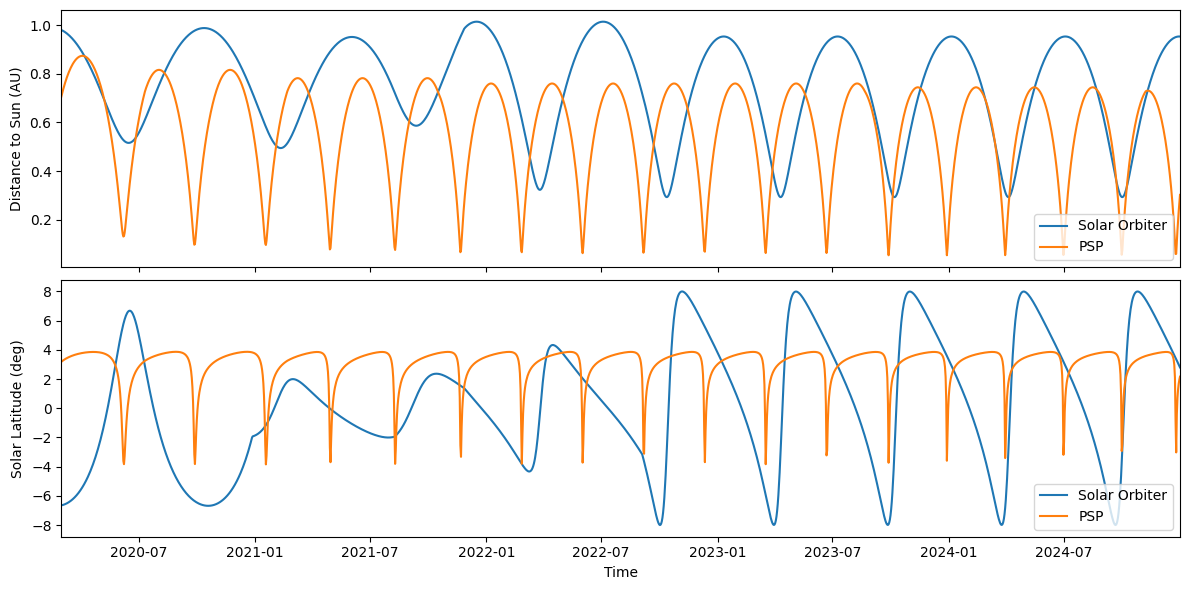

In [118]:
fig, ax = plt.subplots(2, sharex=True, figsize=(12, 6))
ax[0].plot(solo_spacecraft_hgs.obstime.datetime, solo_spacecraft_hgs.radius.to(u.AU), label="Solar Orbiter")
ax[0].plot(psp_spacecraft_hgs.obstime.datetime, psp_spacecraft_hgs.radius.to(u.AU), label="PSP")

ax[1].plot(solo_spacecraft_hgs.obstime.datetime, solo_spacecraft_hgs.lat.to(u.deg), label="Solar Orbiter")
ax[1].plot(psp_spacecraft_hgs.obstime.datetime, psp_spacecraft_hgs.lat.to(u.deg), label="PSP")

ax[0].set_xlim(psp_spacecraft_hgs.obstime.datetime[0], psp_spacecraft_hgs.obstime.datetime[-1])




ax[0].set_xlim(psp_spacecraft_hgs.obstime.datetime[0], psp_spacecraft_hgs.obstime.datetime[-1])
ax[0].set_ylabel("Distance to Sun (AU)")
ax[1].set_ylabel("Solar Latitude (deg)")
ax[1].set_xlabel("Time")
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)